### Whether TV ad campaign influence traffic on the website?

Below analysis is answering the two main questions:
1. **Does the TV ads have impact on number of visitors on the webpage?**

It starts from data manipulation.

After **data cleaning** (correcting the values in *spots*, e.g. time of ad display at 25 o'clock), the information from the *spots* dataframe **was aggregated** and connected to the *visits* dataframe. The hours of ad display were marked (*ad_campaign* with True/False values) and number of ads per hour was counted. 

The mean of website views per day was plotted to check whether there is any trend visible. There was no visible trend, which was confirmed by two applying two modelling methods: **decision tree's classifier and regressor** (on different target variable). It showed complete randomness of the classification and 100% dependence on hours in regression.

2. **What are characteristics of most viewed TV ad?**

**Categorical variables** were dropped (if had too many categories) or transformed into several variables using one-hot encoding. 

Then **decision tree regressor** was applied to GPR target variable (simply total impressions related to the size of the target population). RMSE of the model was close to 0.1 and R2 0.65, thanks to which we can separate **feature importances**.

The results with the source code is presented below.

In [8]:
#load the data and necessary packages
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#for reproductability
SEED=222

visits = pd.read_excel(r'C:\Users\mjawo\Desktop\materials\AMA\exemplary_data.xlsx', sheet_name='visits')
spots = pd.read_excel(r'C:\Users\mjawo\Desktop\materials\AMA\exemplary_data.xlsx', sheet_name='spots')

In [9]:
#dropping irrelevant columnn (or with too many categories)
spots = spots.drop(['Commercial length', 'Title', 'AGB Channel'], axis = 1)

#manipulating time of ad display
spots['Hours'] = spots['Time'].str[0:2]
spots['Hours'] = spots['Hours'].astype(int)

#correcting wrong values (to match 'visits' dataframe)
spots.loc[spots['Hours'] >= 24, 'Date'] += pd.DateOffset(1)
spots.loc[spots['Hours'] == 24, 'Hours'] = 0
spots.loc[spots['Hours'] == 25, 'Hours'] = 1

In [10]:
#merging the dates with hours (common values) to find the periods when ads were displayed
spots['date_hours'] = spots['Date'] + pd.to_timedelta(spots['Hours'], unit='h')
visits['date_hours'] = visits['Data'] + pd.to_timedelta(visits['godzina'], unit='h')

#dropping duplicate columns and setting the index to merge the table with grouped values
visits.index = visits['date_hours']
spots.index = spots['date_hours']

spots = spots.drop(['Date', 'Time'], axis=1)

#adding column - was the campaign on or off?
visits['ad_campaign'] = visits['date_hours'].isin(spots['date_hours'])
visits['ad_campaign'] = pd.to_numeric(visits['ad_campaign'])

In [11]:
#counting how many ads were displayed in particular time
ads_per_hour = pd.DataFrame(spots['date_hours'].value_counts())
ads_per_hour.columns = ['freq']

#date_hours not needed anymore
spots = spots.drop(['date_hours'], axis=1)

#merging tables 
visits = pd.concat([visits, ads_per_hour], axis=1, join='outer')
visits = visits.fillna(0)

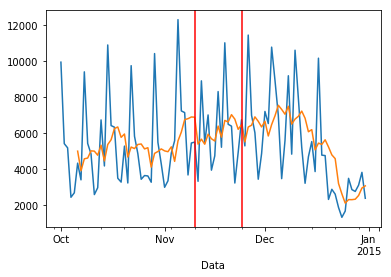

Data
2014-10-22     9742.291667
2014-10-01     9936.458333
2014-12-17    10157.916667
2014-10-29    10414.958333
2014-12-10    10600.958333
2014-12-03    10772.083333
2014-10-15    10892.708333
2014-11-19    11012.791667
2014-11-26    11442.750000
2014-11-05    12299.875000
Name: Wizyty_all, dtype: float64

In [12]:
#plotting the means (per day) of the views in time
visits2 = visits.groupby(['Data'])['Wizyty_all'].mean()
visits2.plot()
#smoothed version of the curve
visits2.rolling(window=6,center=False).mean().plot()

#selecting the period of ad displays.
plt.axvline(x='2014-11-10', color='red')
plt.axvline(x='2014-11-24', color='red')
plt.show()

#selecting 10 days with highest means
visits2.sort_values().tail(10)

## Modelling of *visits* dataframe

In [13]:
y_visits = visits['ad_campaign']
X_visits = visits.drop(columns=['ad_campaign', 'freq', 'date_hours', 'Data'])

X_train_visits, X_test_visits, y_train_visits, y_test_visits = train_test_split(
    X_visits, y_visits, test_size=0.25, stratify=y_visits, random_state=SEED)

tree_visits = DecisionTreeClassifier(max_depth=3, random_state=SEED)
tree_visits.fit(X_train_visits, y_train_visits)
y_pred_visits = tree_visits.predict(X_test_visits)
print(roc_auc_score(y_test_visits, y_pred_visits))
print(confusion_matrix(y_test_visits, y_pred_visits))

0.5
[[470   0]
 [ 82   0]]


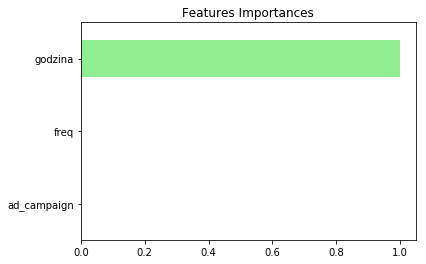

In [14]:
y_visits = visits['Wizyty_all']
X_visits = visits.drop(columns=['Wizyty_all', 'date_hours', 'Data'])

X_train_visits, X_test_visits, y_train_visits, y_test_visits = train_test_split(
    X_visits, y_visits, test_size=0.25, random_state=SEED)

tree_visits = DecisionTreeRegressor(max_depth=3, random_state=SEED)
tree_visits.fit(X_train_visits, y_train_visits)
y_pred_visits = tree_visits.predict(X_test_visits)


#plotting the importances
importances = pd.Series(data=tree_visits.feature_importances_,
                        index= X_train_visits.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

## Modelling of *spots* dataframe

In [15]:
#creating dummy variables
channel = pd.get_dummies(spots['Campaign Channel'])
day = pd.get_dummies(spots['Timeband'])
breaktype = pd.get_dummies(spots['BreakType (Block type)'])
position = pd.get_dummies(spots['Position Type in the block of commercials'])

#dropping original columns
spots = pd.concat([spots, channel, day, breaktype, position], axis=1, join='outer')
spots = spots.drop(
    columns=['Campaign Channel','Timeband','BreakType (Block type)','Position Type in the block of commercials'])


In [16]:
y_spots = spots['GRP']
X_spots = spots.drop(columns='GRP')

X_train_spots, X_test_spots, y_train_spots, y_test_spots = train_test_split(
    X_spots, y_spots, test_size=0.25, random_state=SEED)

tree_spots = DecisionTreeRegressor(max_depth=7, random_state=SEED)
tree_spots.fit(X_train_spots, y_train_spots)
y_pred_spots = tree_spots.predict(X_test_spots)
print(mean_squared_error(y_pred_spots, y_test_spots)**1/2)
print(r2_score(y_pred_spots, y_test_spots))

0.10824973457567165
0.656005817709928


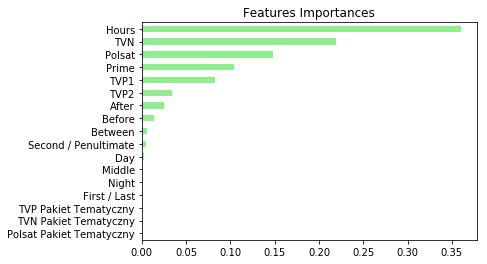

In [17]:
importances2 = pd.Series(data=tree_spots.feature_importances_,
                        index= X_train_spots.columns)

# Sort importances
importances_sorted = importances2.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()